# Preparation

<b>Load Libraries</b>

In [1]:
# udf and udc
import os, sys
cwd = os.getcwd()
os.chdir('..')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.jupyter.support import *

# visualizations
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme('notebook')
sns.set_style('whitegrid')
import squarify
import statsmodels.api as sm

<b>Load Dataset</b>

In [2]:
# dataset
df_base = pd.read_csv('../resource/data/raw.csv')

In [3]:
# clone
df_cleaned = df_base.copy()

<b>UDF</b>

In [21]:
# hist + box + qq
def plot_hist(ax, name: str):
    g = sns.histplot(df_cleaned[name], color=sns.color_palette('tab10')[0], alpha=.75, kde=True, ax=ax)
    g.axes.lines[0].set_color('r'); g.axes.lines[0].set_linewidth(2)
    g.set_ylabel(None)
    ##
    mean = df_cleaned[name].mean()
    _, ylim = g.get_ylim()
    g.axvline(mean, linestyle='--', color='black')
    g.annotate('Mean', xy=(mean, ylim*.75), xytext=(mean*.35, ylim*.5), 
               arrowprops=dict(arrowstyle='->', color='black'))

def plot_box(ax, name: str):
    sns.boxplot(df_cleaned[name], showmeans=True, orient='h', fill=False,
                meanprops=dict(markerfacecolor='red', markersize=9, markeredgecolor='black'),
                ax=ax)

def plot_qq(ax, name: str):
    sm.qqplot(df_cleaned[name], line='r', ax=ax)

# tree map
def plot_treemap(ax, name: str):
    ##
    data_to_plot = df_cleaned[name].value_counts()
    sizes = data_to_plot.values.tolist()
    labels = [f'{label}\n({size})' for label, size in zip(data_to_plot.index.tolist(), sizes)]
    ##
    g = squarify.plot(sizes=sizes, label=labels, color=sns.husl_palette(n_colors=len(sizes)), 
                  ax=ax)
    g.set_title(name, fontdict=dict(size=20))

<b>MLflow</b>

# 1. Data Wrangling

<b>General</b>

In [5]:
# shape
df_base.shape

(4250, 20)

In [6]:
# head
df_base.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


In [7]:
# tail
df_base.tail()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
4245,MT,83,area_code_415,no,no,0,188.3,70,32.01,243.8,88,20.72,213.7,79,9.62,10.3,6,2.78,0,no
4246,WV,73,area_code_408,no,no,0,177.9,89,30.24,131.2,82,11.15,186.2,89,8.38,11.5,6,3.11,3,no
4247,NC,75,area_code_408,no,no,0,170.7,101,29.02,193.1,126,16.41,129.1,104,5.81,6.9,7,1.86,1,no
4248,HI,50,area_code_408,no,yes,40,235.7,127,40.07,223.0,126,18.96,297.5,116,13.39,9.9,5,2.67,2,no
4249,VT,86,area_code_415,no,yes,34,129.4,102,22.00,267.1,104,22.70,154.8,100,6.97,9.3,16,2.51,0,no


In [8]:
# info
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4250 entries, 0 to 4249
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          4250 non-null   object 
 1   account_length                 4250 non-null   int64  
 2   area_code                      4250 non-null   object 
 3   international_plan             4250 non-null   object 
 4   voice_mail_plan                4250 non-null   object 
 5   number_vmail_messages          4250 non-null   int64  
 6   total_day_minutes              4250 non-null   float64
 7   total_day_calls                4250 non-null   int64  
 8   total_day_charge               4250 non-null   float64
 9   total_eve_minutes              4250 non-null   float64
 10  total_eve_calls                4250 non-null   int64  
 11  total_eve_charge               4250 non-null   float64
 12  total_night_minutes            4250 non-null   f

In [9]:
# stripping
##
df_cleaned.columns = [name.strip() for name in df_cleaned.columns.tolist()]
num_cols = df_cleaned.select_dtypes(np.number).columns.tolist()
cat_cols = df_cleaned.select_dtypes('object').columns.tolist()
##
df_cleaned[cat_cols] = df_cleaned[cat_cols].map(lambda x: x.strip())

In [10]:
# null strings
null_strings_cols = (df_cleaned[cat_cols] == '').sum(axis=0)\
    .to_frame('count').query('count != 0').index.tolist()
print(f'Total columns with null strings: {len(null_strings_cols)} \n{null_strings_cols}')

Total columns with null strings: 0 
[]


In [11]:
# single-value columns
single_value_cols = df_cleaned.nunique().to_frame('nunique')\
    .query('nunique == 1').index.tolist()
print(f'Total columns with single value: {len(single_value_cols)} \n{single_value_cols}')

Total columns with single value: 0 
[]


In [12]:
# spelling
for name in cat_cols:
    print(f'{name}: {df_cleaned[name].unique()}')

state: ['OH' 'NJ' 'OK' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY' 'ID' 'VA'
 'TX' 'FL' 'CO' 'AZ' 'SC' 'WY' 'HI' 'NH' 'AK' 'GA' 'MD' 'AR' 'WI' 'OR'
 'MI' 'DE' 'UT' 'CA' 'SD' 'NC' 'WA' 'MN' 'NM' 'NV' 'DC' 'VT' 'KY' 'ME'
 'MS' 'AL' 'NE' 'KS' 'TN' 'IL' 'PA' 'CT' 'ND']
area_code: ['area_code_415' 'area_code_408' 'area_code_510']
international_plan: ['no' 'yes']
voice_mail_plan: ['yes' 'no']
churn: ['no' 'yes']


<b>Additional</b>

In [13]:
# missing values
mask = df_cleaned.isnull()
counts = mask.sum(axis=0)
print(f'Total missing values per column: \n{counts}')

Total missing values per column: 
state                            0
account_length                   0
area_code                        0
international_plan               0
voice_mail_plan                  0
number_vmail_messages            0
total_day_minutes                0
total_day_calls                  0
total_day_charge                 0
total_eve_minutes                0
total_eve_calls                  0
total_eve_charge                 0
total_night_minutes              0
total_night_calls                0
total_night_charge               0
total_intl_minutes               0
total_intl_calls                 0
total_intl_charge                0
number_customer_service_calls    0
churn                            0
dtype: int64


In [14]:
# duplications
mask = df_cleaned.duplicated()
counts = mask.sum(axis=0)
print(f'Total duplications: {counts}')

Total duplications: 0


<b>Finalize</b>

In [15]:
df_cleaned.to_csv('../resource/data/cleaned.csv', index=False)

# 2.1 EDA - General

<b>Univariate</b>

In [19]:
# summarize statistics
df_cleaned[num_cols].describe([0.01, 0.25, 0.5, 0.75, 0.99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
account_length,4250.0,100.236235,39.698401,1.0,13.0000,73.0000,100.00,127.0000,194.0000,243.00
number_vmail_messages,4250.0,7.631765,13.439882,0.0,0.0000,0.0000,0.00,16.0000,43.0000,52.00
total_day_minutes,4250.0,180.259600,54.012373,0.0,55.0450,143.3250,180.45,216.2000,304.8550,351.50
total_day_calls,4250.0,99.907294,19.850817,0.0,54.0000,87.0000,100.00,113.0000,145.5100,165.00
total_day_charge,4250.0,30.644682,9.182096,0.0,9.3592,24.3650,30.68,36.7500,51.8259,59.76
total_eve_minutes,4250.0,200.173906,50.249518,0.0,80.2940,165.9250,200.70,233.7750,318.6510,359.30
total_eve_calls,4250.0,100.176471,19.908591,0.0,54.0000,87.0000,100.00,114.0000,147.0000,170.00
total_eve_charge,4250.0,17.015012,4.271212,0.0,6.8245,14.1025,17.06,19.8675,27.0851,30.54
total_night_minutes,4250.0,200.527882,50.353548,0.0,81.9430,167.2250,200.45,234.7000,317.5550,395.00
total_night_calls,4250.0,99.839529,20.093220,0.0,53.4900,86.0000,100.00,113.0000,147.5100,175.00


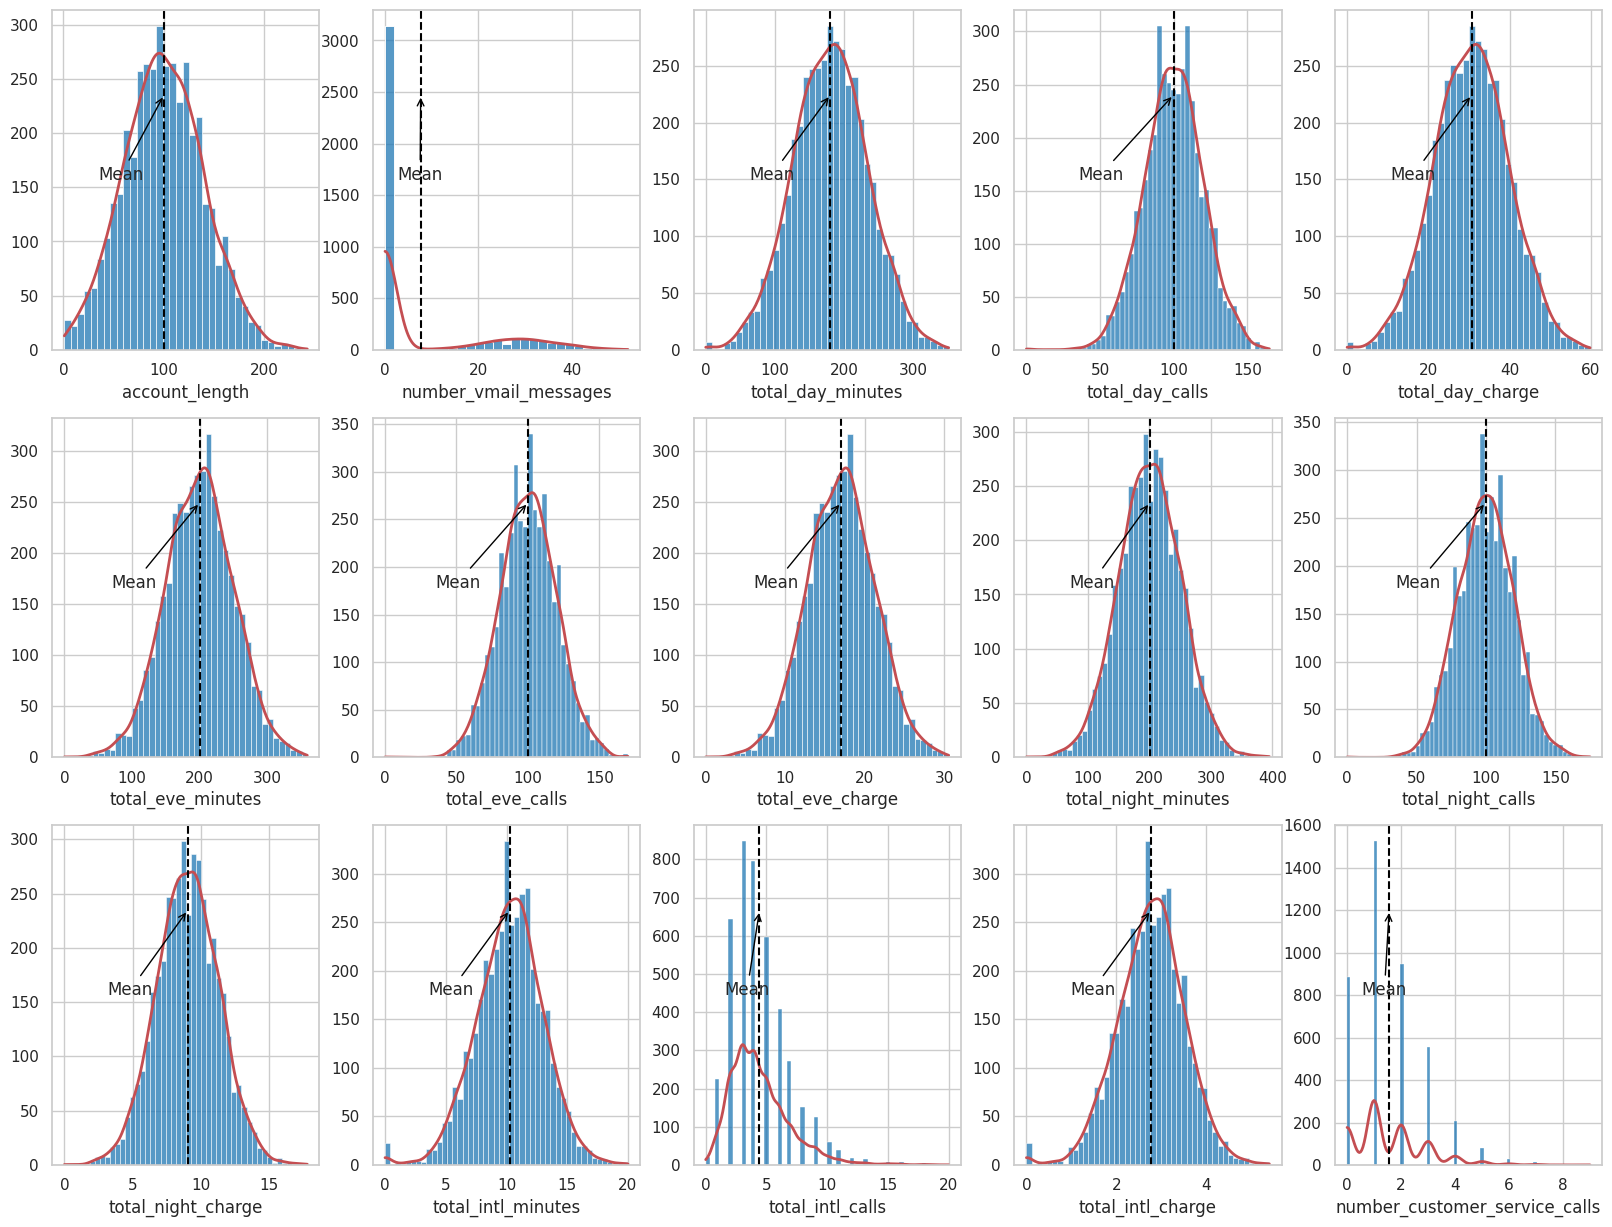

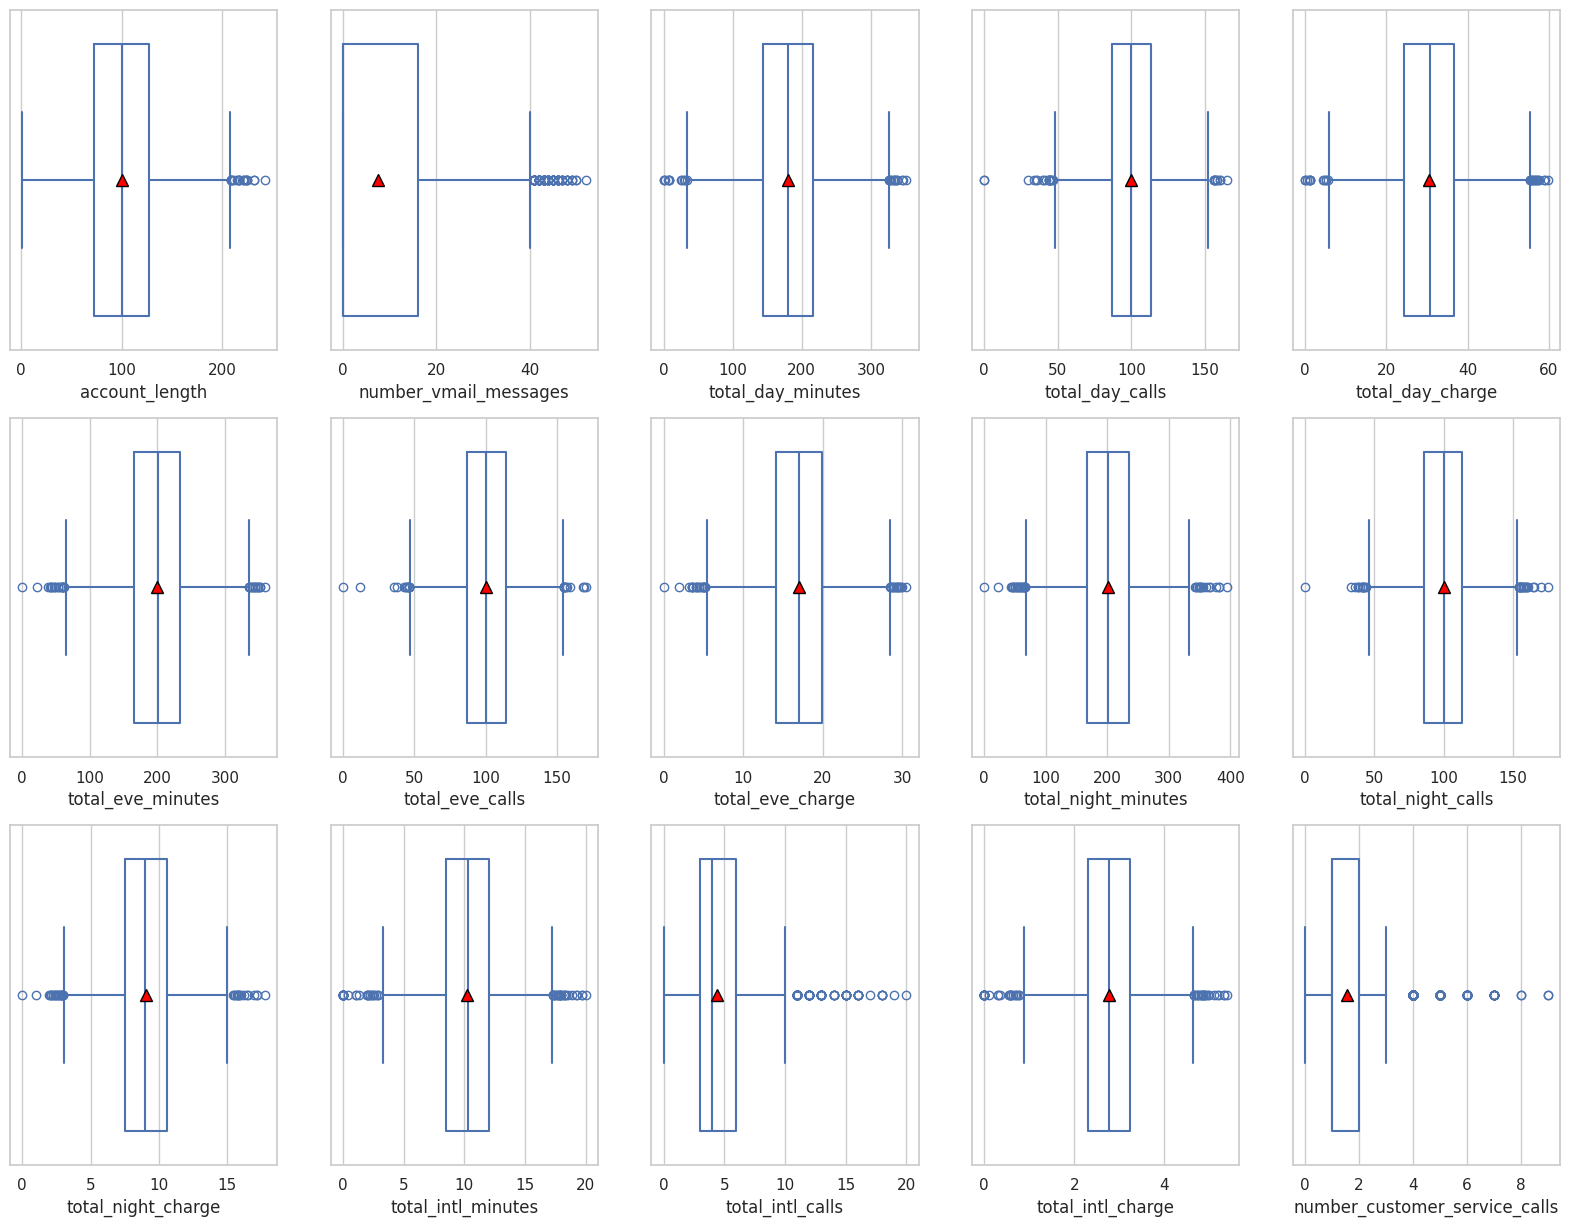

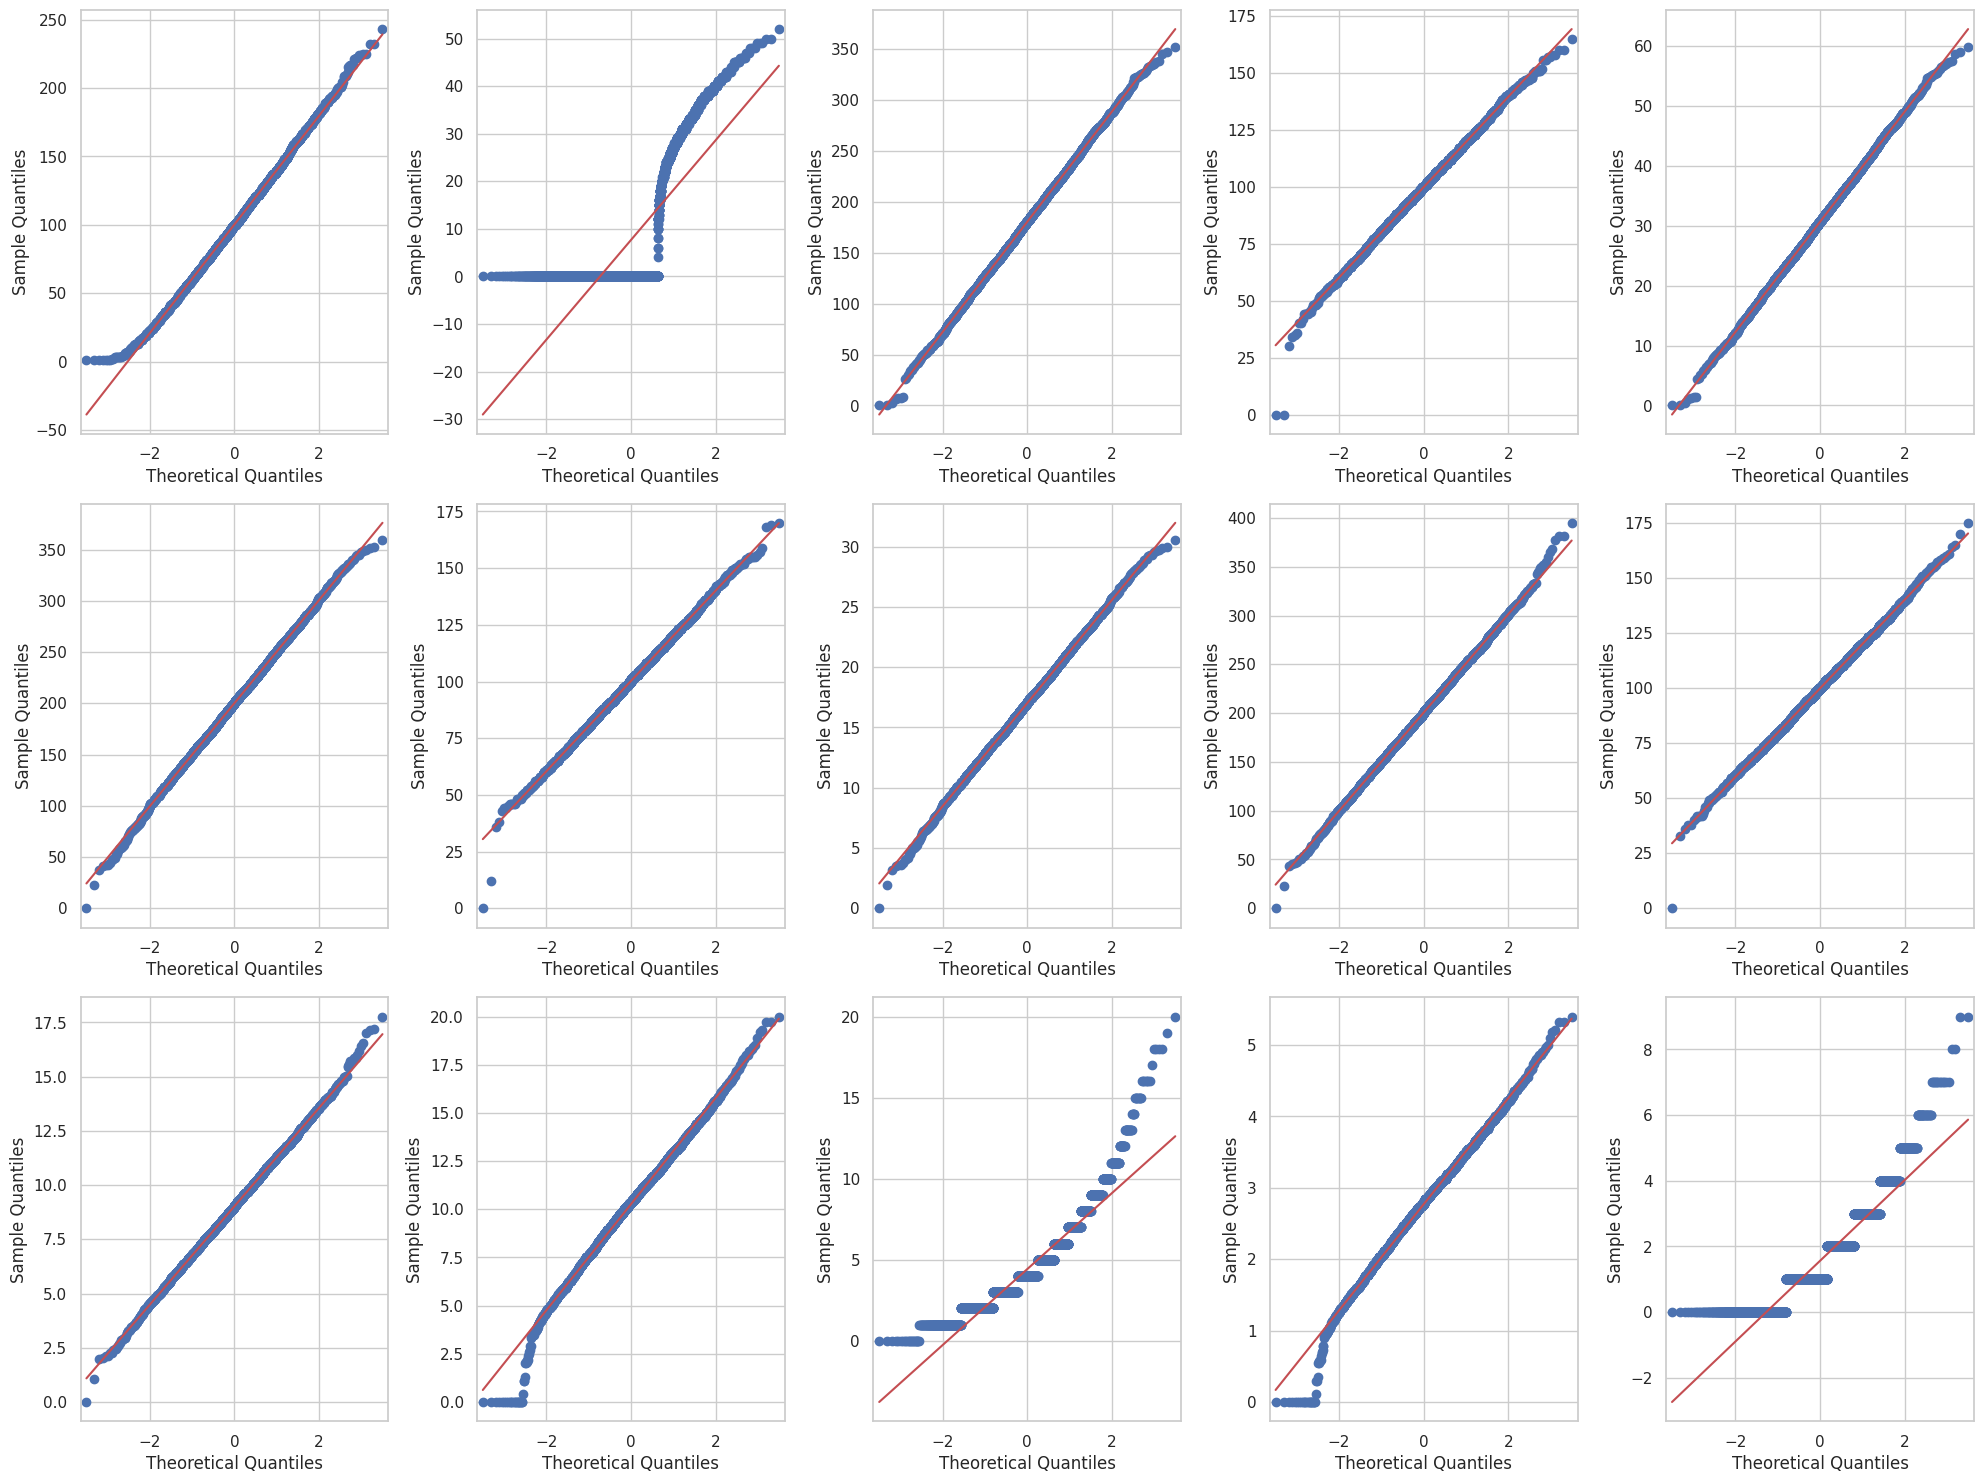

In [120]:
# graphs: hist + box + qq
##
graphs = ['hist', 'box', 'qq']
figs, axes = dict(), dict()
for name in graphs:
    figs[name], axes[name] = plt.subplots(3, 5, sharex=False, sharey=False, figsize=(20, 15))
##
names = np.array(num_cols).reshape(3, 5)
##
for i in range(3):
    for j in range(5):
        plot_hist(axes['hist'][i, j], names[i, j])
        plot_box(axes['box'][i, j], names[i, j])
        plot_qq(axes['qq'][i, j], names[i, j])

for name in graphs:
    figs[name].savefig(f'../resource/jupyter/image/eda_univariate_{name}.png')

plt.tight_layout()
plt.show()

In [16]:
# summarize statistics
df_cleaned[cat_cols].describe().T

,count,unique,top,freq
state,4250,51,WV,139
area_code,4250,3,area_code_415,2108
international_plan,4250,2,no,3854
voice_mail_plan,4250,2,no,3138
churn,4250,2,no,3652


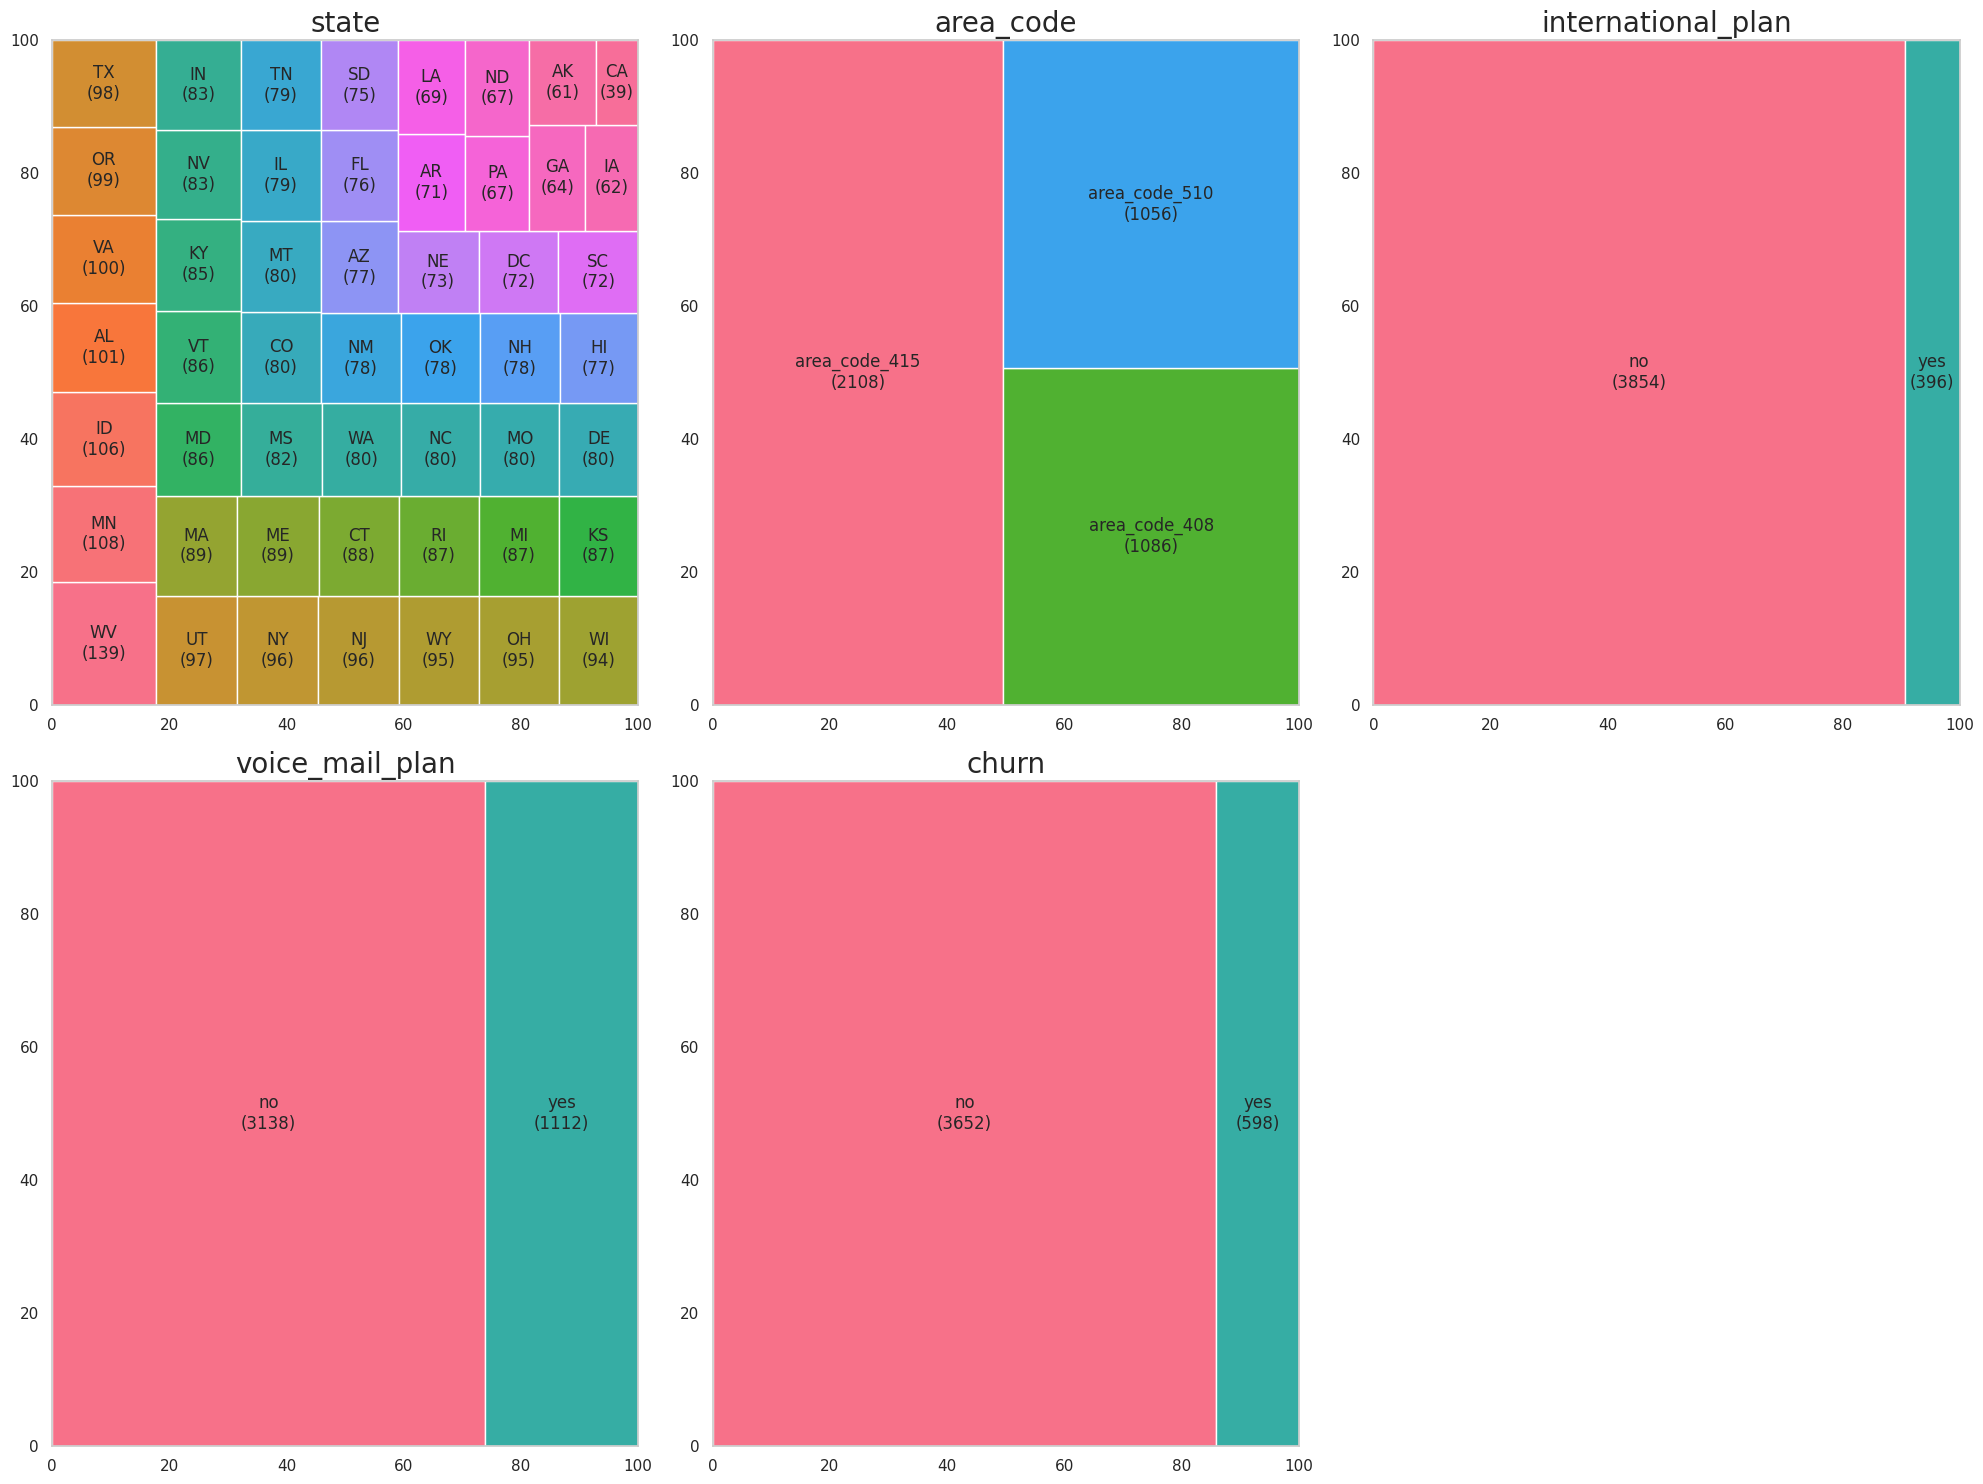

In [23]:
# tree map 
fig, ax = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))
##
names = cat_cols.copy()
names.append('0')
names = np.array(names).reshape(2, 3)
##
for i in range(2):
    for j in range(3):
        if names[i, j] != '0':
            plot_treemap(ax[i, j], names[i, j])
        else:
            ax[i, j].set_visible(False)

fig.savefig('../resource/jupyter/image/eda_univariate_treemap.png')

plt.tight_layout()
plt.show()

<b>Bivariate</b>

Correlations're over 0.5:
total_day_charge ~ total_day_minutes
total_eve_charge ~ total_eve_minutes
total_night_charge ~ total_night_minutes
total_intl_charge ~ total_intl_minutes


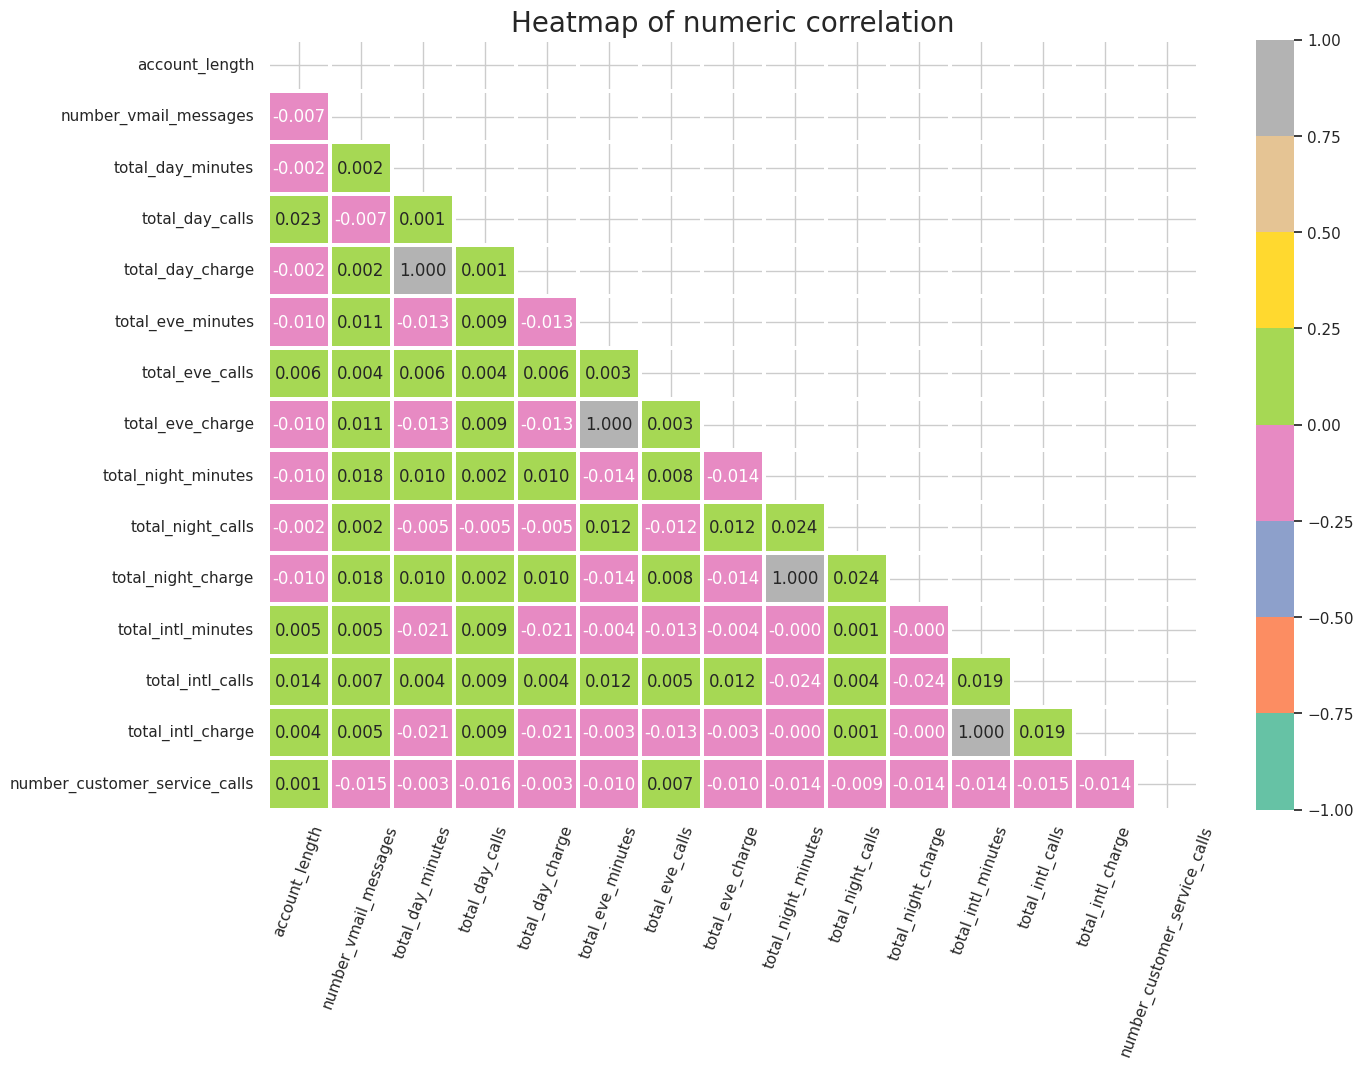

In [47]:
# correlation
corr = df_cleaned[num_cols].corr()
##
print('Correlations\'re over 0.5:')
num_iters, i = len(num_cols), 1
while i < num_iters:
    for j in range(i):
        if corr.iloc[i, j] >= 0.5:
            print(f'{num_cols[i]} ~ {num_cols[j]}')
    
    i += 1
##
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
g = sns.heatmap(corr, mask=mask, vmin=-1, vmax=1, 
                annot=True, fmt='.3f', cmap='Set2', linewidths=1.5)
g.axes.tick_params(axis='x', rotation=70)
g.set_title('Heatmap of numeric correlation', fontdict=dict(size=20))
##
fig.savefig('../resource/jupyter/image/eda_bivariate_numeric_corr.png')

plt.show()